# This has the resplit train/val/test for balance and is using a simple random forest. We call ancestor lab "second order" or "SO" internally.

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import random
import os

random.seed(42)
np.random.seed(42)
sys.path.append('../')
from common.plot_style_utils import set_pub_plot_context, save_for_pub
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
classes_seqonly = np.load("../../data/results/rf/classes_for_predictions_second_order_fixed_seqonly_simplemodel.npy")
classes_seqmeta = np.load("../../data/results/rf/classes_for_predictions_second_order_fixed_seq_meta_simplemodel.npy")

In [3]:
classes_seqonly

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [4]:
classes_seqmeta

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [5]:
class_labels = classes_seqonly

In [6]:
val = {
    "seqonly": np.load(
        "../../data/results/rf/predictions_val_second_order_fixed_seqonly_simplemodel.npy"
    ),
    "seqmeta": np.load(
        "../../data/results/rf/predictions_val_second_order_fixed_seq_meta_simplemodel.npy"
    )
}
train = {
    "seqonly": np.load(
        "../../data/results/rf/predictions_train_second_order_fixed_seqonly_simplemodel.npy"
    ),
    "seqmeta": np.load(
        "../../data/results/rf/predictions_train_second_order_fixed_seq_meta_simplemodel.npy"
    )
}
test = {
    "seqonly": np.load(
    "../../data/results/rf/predictions_TEST_second_order_fixed_seqonly_simplemodel.npy"
    ),
    "seqmeta": np.load(
    "../../data/results/rf/predictions_TEST_second_order_fixed_seq_meta_simplemodel.npy"
    )
}
predictions = {
    "val":val,
    "train":train,
    "test":test
}

true = {
    "val": np.load("../../data/tts/y_val_SO_fixed.pkl"),
    "train": np.load("../../data/tts/y_train_SO_fixed.pkl"),
    "test": np.load("../../data/tts/y_test_SO_fixed.pkl")
}



In [7]:
for i, v in predictions.items():
    print(i)
    print(v["seqonly"].shape)
    print(v["seqmeta"].shape)
    print("\n\n")

val
(2181, 188)
(2181, 188)



train
(13076, 188)
(13076, 188)



test
(2169, 188)
(2169, 188)





In [8]:
for i, v in true.items():
    print(i)
    print(v.shape)
    print("\n\n")

val
(2181,)



train
(13076,)



test
(2169,)





In [9]:
def get_rf_labels(true,class_labels):
    tmp = [np.flatnonzero(class_labels == v) for v in true]
    return np.array([-1 if len(v) == 0 else v[0] for v in tmp])

def acc(pred, true, class_labels=class_labels):
    index = np.argmax(pred, axis=1)
    classes = class_labels[index]
    correct = (classes == true)
    #print(true.shape)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def best_guess(true, 
               train_y=true['train'], 
               class_labels=class_labels,
                k=1
              ):
    """ 
    Guesses most abundant class in the training set.
    """
    guess = np.argsort(
        np.bincount(np.asarray(train_y, dtype=int))
    )[-k:]
    correct = np.isin(true,guess)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def topkacc(pred,true,k,class_labels=class_labels):
    topkindices = np.argsort(pred)[:,-k:]
    print(true.shape)
    true = get_rf_labels(true, class_labels)
    #print(f"True is {true.shape}, preds is {topkindices.shape}")
    correct = ((topkindices == true[:,None]).any(axis=1))
    #print(len(true))
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [10]:
print(topkacc(predictions['train']['seqonly'], true['train'], 1))
print(acc(predictions['train']['seqonly'], true['train']))

(13076,)
1.0
1.0


In [11]:
for name in ["val", "train", "test"]:
    print(f"{name} scores")
    print(f"Best guess\n {best_guess(true[name])}")
    print(f"Sequence only")
    print(f"Accuracy = {acc(predictions[name]['seqonly'], true[name])} \t Top10 = {topkacc(predictions[name]['seqonly'], true[name], 10)}")
    print(f"Sequence and Metadata")      
    print(f"Accuracy = {acc(predictions[name]['seqmeta'], true[name])} \t Top10 = {topkacc(predictions[name]['seqmeta'], true[name], 10)} \n")

val scores
Best guess
 0.14534617148097204
Sequence only
(2181,)
Accuracy = 0.8262265016047684 	 Top10 = 0.9390187987161852
Sequence and Metadata
(2181,)
Accuracy = 0.8830811554332875 	 Top10 = 0.9679046309032554 

train scores
Best guess
 0.18331293973692261
Sequence only
(13076,)
Accuracy = 1.0 	 Top10 = 1.0
Sequence and Metadata
(13076,)
Accuracy = 1.0 	 Top10 = 1.0 

test scores
Best guess
 0.13646841862609496
Sequence only
(2169,)
Accuracy = 0.8054402950668511 	 Top10 = 0.9326878745965883
Sequence and Metadata
(2169,)
Accuracy = 0.8704472106961734 	 Top10 = 0.9649608114338405 



In [12]:
labels = ["RF", "Baseline", "Uniform"]
top1 = [acc(predictions['test']['seqmeta'], true['test']),
        best_guess(true['test'],k=1),
        1 / len(np.unique(true['train']))
       ]
top10 = [topkacc(predictions['test']['seqmeta'], true['test'], 10),
         best_guess(true['test'],k=10),
         10 / len(np.unique(true['train']))
        ]

(2169,)


In [13]:
df = pd.DataFrame({'Method':labels*2, "Accuracy":top1 + top10, 
                   "Top k":["k=1"] * 3 + ["k=10"]*3})

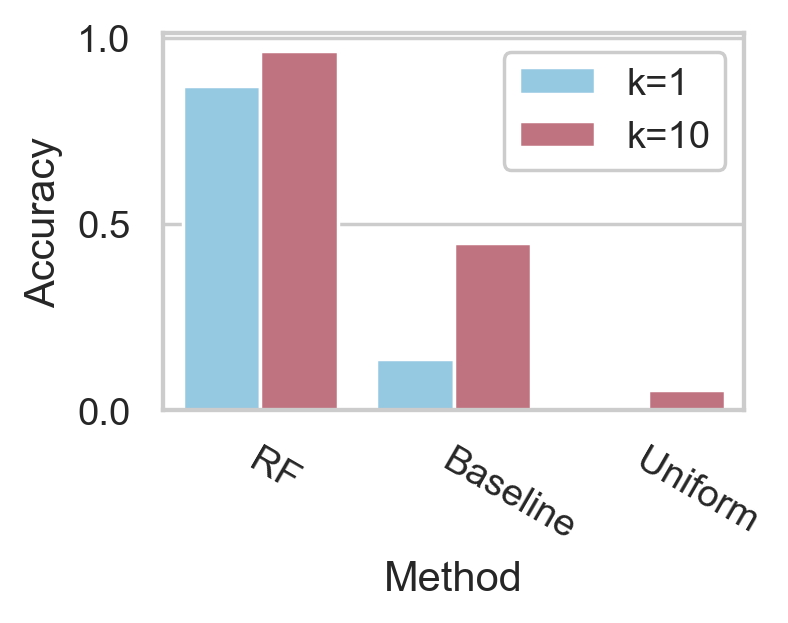

In [14]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(3,2), dpi=250)
ax1 = fig.add_subplot(111,
                    xlabel="Accuracy")
palette = sns.color_palette()
#colors = [palette[0], palette[1], palette[0], palette[0]]
#sns.barplot(y='labels', x='top1', hue='hue', data=df,alpha=1)
sns.barplot(y="Accuracy", x="Method", hue="Top k", data=df, alpha=1, ax=ax1, )#dodge=False)#kwargs={"legend":False})
plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
plt.legend(loc='upper right', framealpha=1)
!mkdir ../../data/manuscript/figs/4/f_bar
save_for_pub(fig, path="../../data/manuscript/figs/4/f_bar/v0", dpi=500)

In [15]:
df

,Method,Accuracy,Top k
0,RF,0.870447,k=1
1,Baseline,0.136468,k=1
2,Uniform,0.005319,k=1
3,RF,0.964961,k=10
4,Baseline,0.449977,k=10
5,Uniform,0.053191,k=10


In [16]:
len(np.unique(true['train']))

188